<a href="https://colab.research.google.com/github/Jeongchan-Kim/COVID-CT-classification/blob/main/Covid_CT_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Covid_Dataset.zip

Archive:  /content/drive/MyDrive/Covid_Dataset.zip
   creating: Covid_Dataset/
  inflating: __MACOSX/._Covid_Dataset  
   creating: Covid_Dataset/Covid_Train/
  inflating: __MACOSX/Covid_Dataset/._Covid_Train  
  inflating: Covid_Dataset/.DS_Store  
  inflating: __MACOSX/Covid_Dataset/._.DS_Store  
   creating: Covid_Dataset/Covid_Test/
  inflating: __MACOSX/Covid_Dataset/._Covid_Test  
   creating: Covid_Dataset/Covid_Valid/
  inflating: __MACOSX/Covid_Dataset/._Covid_Valid  
   creating: Covid_Dataset/Covid_Train/1_CT_COVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Train/._1_CT_COVID  
   creating: Covid_Dataset/Covid_Train/0_CT_NonCOVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Train/._0_CT_NonCOVID  
   creating: Covid_Dataset/Covid_Test/1_CT_COVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Test/._1_CT_COVID  
   creating: Covid_Dataset/Covid_Test/0_CT_NonCOVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Test/._0_CT_NonCOVID  
   creating: Covid_Dataset/Covid_Valid/1_CT_COVID/
  i

In [ ]:
root_dir = '/content/Covid_Dataset/'

# **Data Preprocessing**

In [ ]:
import random
import os 
import cv2
import matplotlib.pyplot as plt

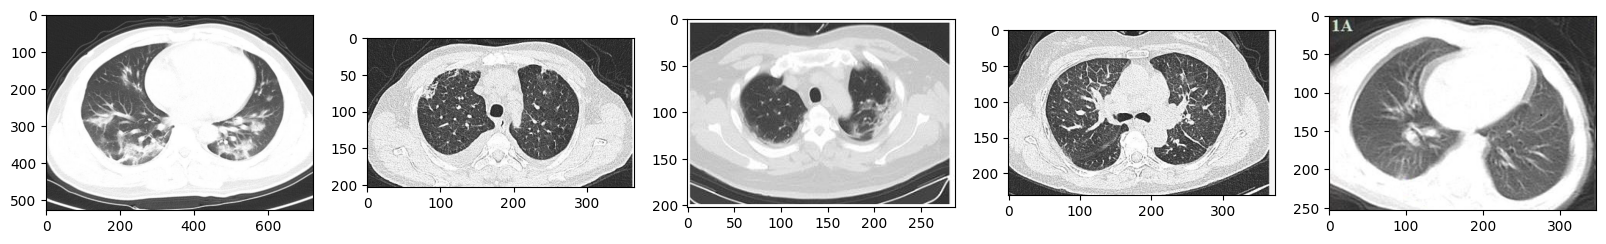

In [ ]:
# checking Covid data randomly
covid_train_path = os.path.join(root_dir, 'Covid_Train', '1_CT_COVID')

covid_files      = [os.path.join(covid_train_path, x) for x in os.listdir(covid_train_path)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(int(len(covid_images) / columns + 1), columns, i + 1)
    plt.imshow(image)

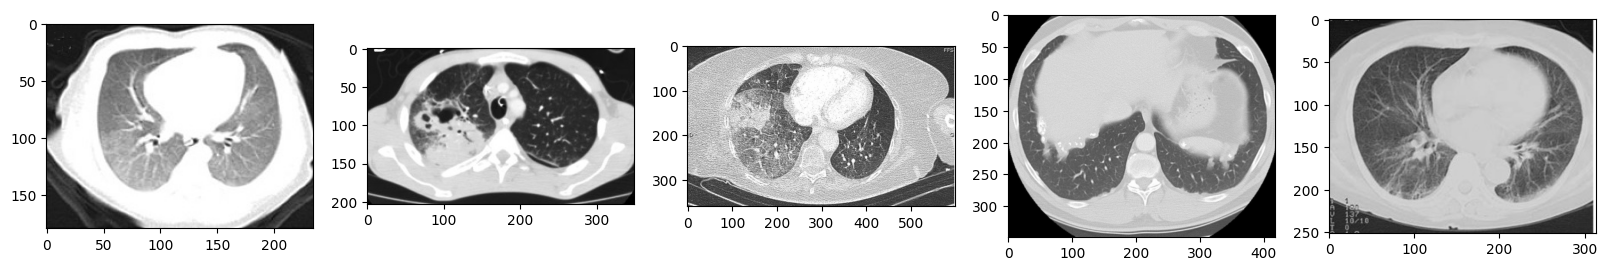

In [ ]:
# checking Non-Covid data randomly
covid_train_path = os.path.join(root_dir, 'Covid_Train', '0_CT_NonCOVID')

covid_files      = [os.path.join(covid_train_path, x) for x in os.listdir(covid_train_path)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(int(len(covid_images) / columns + 1), columns, i + 1)
    plt.imshow(image)

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.utils.data as data

In [ ]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed = 2022

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

np.random.seed(random_seed)
random.seed(random_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#data Transform
normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
image_transforms = {
    'train': transforms.Compose([
    transforms.Resize(256),  
    
    # data augmentation
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    
    transforms.ToTensor(),
    normalize
    ]),

    'valid': transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
}

In [ ]:
train_dataset_folder = root_dir + 'Covid_Train'
val_dataset_folder = root_dir + 'Covid_Valid'
test_dataset_folder = root_dir + 'Covid_Test'

In [ ]:
train_dataset = datasets.ImageFolder(root=train_dataset_folder, transform=image_transforms['train'])
valid_dataset = datasets.ImageFolder(root=val_dataset_folder, transform=image_transforms['valid'])
test_dataset = datasets.ImageFolder(root=test_dataset_folder, transform=image_transforms['valid'])

In [ ]:
# hyperparameter for DataLoader

train_params = {
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 1,
    'drop_last': False}

valid_params = {
    'batch_size': 64,
    'shuffle': False,
    'num_workers': 1,
    'drop_last': False}

In [ ]:
train_loader = data.DataLoader(train_dataset, **train_params)
valid_loader = data.DataLoader(valid_dataset, **valid_params)
test_loader = data.DataLoader(test_dataset, **valid_params)

In [ ]:
# Checking Train DataLoader Data
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [ ]:
# Checking Valid DataLoader Data
for x, y in valid_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


# **Distribution of Data**

In [ ]:
import os

In [ ]:
def print_files_in_dir(root_dir, prefix):
    files = os.listdir(root_dir)
    lab = ['COVID', "Non-COVID"]
    for i, file in enumerate(files):
        path = os.path.join(root_dir, file)
        file_list = os.listdir(path)
        print(f"{prefix} 데이터의 {lab[i]} 수: {len(file_list)}")

In [ ]:
phase = "Train"
print_files_in_dir(root_dir + f"Covid_{phase}", phase)
print()
phase = "Valid"
print_files_in_dir(root_dir + f"Covid_{phase}", phase)
print()
phase = "Test"
print_files_in_dir(root_dir + f"Covid_{phase}", phase)

Train 데이터의 COVID 수: 234
Train 데이터의 Non-COVID 수: 191

Valid 데이터의 COVID 수: 58
Valid 데이터의 Non-COVID 수: 60

Test 데이터의 COVID 수: 105
Test 데이터의 Non-COVID 수: 98


# **MODEL**

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
config = {
    # Classfier 설정
    "cls_hidden_dims" : []
    }

In [ ]:
class CovidResNet(nn.Module):
    
    def __init__(self):

        super(CovidResNet, self).__init__()

        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        self.num_ftrs = num_ftrs
        
        for name, param in model.named_parameters():
            if 'layer2' in name:
                break
            param.requires_grad = False

        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        b = x.size(0)
        x = x.view(b, -1)

        return x

In [ ]:
model_image = CovidResNet()
model_image

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


CovidResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [ ]:
class Classifier(nn.Sequential):

    def __init__(self, model_image, **config):

        super(Classifier, self).__init__()

        self.model_image = model_image # image 임베딩 모델

        self.input_dim = model_image.num_ftrs # image feature 사이즈
        self.dropout = nn.Dropout(0.1) # dropout 적용

        self.hidden_dims = config['cls_hidden_dims'] # classifier hidden dimensions
        layer_size = len(self.hidden_dims) + 1 # hidden layer 개수
        dims = [self.input_dim] + self.hidden_dims + [2] 

        self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)]) # classifer layers 

    def forward(self, v):
        # Drug/protein 임베딩
        v_i = self.model_image(v) # batch_size x hidden_dim 

        for i, l in enumerate(self.predictor):
            if i == (len(self.predictor)-1):
                # If last layer,
                v_i = l(v_i)
            else:
                # If Not last layer, dropout과 ReLU 적용
                v_i = F.relu(self.dropout(l(v_i)))

        return v_i

In [ ]:
model = Classifier(model_image, **config)
model

Classifier(
  (model_image): CovidResNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

# **Model Training**

In [ ]:
import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

In [ ]:
# hyperparameter 
learning_rate = 0.0001
train_epoch   = 20

In [ ]:
# optimizer 
opt     = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
loss_history_train = []
loss_history_val = []

max_acc = 0

# 모델 GPU 메모리에 올리기
model = model.to(device)

# Best 모델 초기화
model_best = copy.deepcopy(model)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ["# epoch"] 
valid_metric_header.extend(["Accuracy", "sensitivity", "specificity", "roc_score"])
table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x

# 학습 진행
print('--- Go for Training ---')
# 학습 시작 시간 기록 
t_start = time() 

for epo in range(train_epoch):
    # Model training 
    model.train()
    
    # Mini-batch 학습 
    for i, (v_i, label) in enumerate(train_loader):
        # input data gpu에 올리기 
        v_i = v_i.float().to(device) 
        # forward-pass
        output = model(v_i) 

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산 
        loss = loss_fn(output, label.to(device))

        # 각 iteration 마다 loss 기록 
        loss_history_train.append(loss.item())

        # gradient 초기화
        opt.zero_grad()
        # back propagation
        loss.backward()
        # parameter update
        opt.step()
    
    # gradient tracking X
    with torch.set_grad_enabled(False):
        
        y_pred = []
        y_score = []
        y_label = []
        # model validation
        model.eval()

        for i, (v_i, label) in enumerate(valid_loader):
            # validation 입력 데이터 gpu에 올리기
            v_i = v_i.float().to(device)

            # forward-pass
            output = model(v_i)

            # 미리 정의한 손실함수(MSE)로 손실(loss) 계산 
            loss = loss_fn(output, label.to(device))

            # 각 iteration 마다 loss 기록 
            loss_history_val.append(loss.item())

            pred = output.argmax(dim=1, keepdim=True)
            score = nn.Softmax(dim = 1)(output)[:,1]

            # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
            pred = pred.cpu().numpy()
            score = score.cpu().numpy()
            label = label.cpu().numpy()

            # 예측값, 참값 기록하기
            y_label = y_label + label.flatten().tolist()
            y_pred = y_pred + pred.flatten().tolist()
            y_score = y_score + score.flatten().tolist()
    
    # metric 계산
    classification_metrics = classification_report(y_label, y_pred,
                        target_names = ['CT_NonCOVID', 'CT_COVID'],
                        output_dict= True)
    
    # sensitivity is the recall of the positive class
    sensitivity = classification_metrics['CT_COVID']['recall']
    # specificity is the recall of the negative class 
    specificity = classification_metrics['CT_NonCOVID']['recall']
    # accuracy
    accuracy = classification_metrics['accuracy']
    # confusion matrix
    conf_matrix = confusion_matrix(y_label, y_pred)
    # roc score
    roc_score = roc_auc_score(y_label, y_score)

    # 계산한 metric 합치기
    lst = ["epoch " + str(epo)] + list(map(float2str,[accuracy, sensitivity, specificity, roc_score]))

    # 각 epoch 마다 결과값 pretty table에 기록
    table.add_row(lst)
    valid_metric_record.append(lst)
    
    # mse 기준으로 best model 업데이트
    if accuracy > max_acc:
        # best model deepcopy 
        model_best = copy.deepcopy(model)
        # max MSE 업데이트 
        max_acc = accuracy

    # 각 epoch 마다 결과 출력 
    print('Validation at Epoch '+ str(epo + 1) + ' , Accuracy: ' + str(accuracy)[:7] + ' , sensitivity: '\
						 + str(sensitivity)[:7] + ', specificity: ' + str(f"{specificity}") +' , roc_score: '+str(roc_score)[:7])


--- Go for Training ---
Validation at Epoch 1 , Accuracy: 0.59322 , sensitivity: 0.36666, specificity: 0.8275862068965517 , roc_score: 0.63994
Validation at Epoch 2 , Accuracy: 0.62711 , sensitivity: 0.3, specificity: 0.9655172413793104 , roc_score: 0.75977
Validation at Epoch 3 , Accuracy: 0.68644 , sensitivity: 0.48333, specificity: 0.896551724137931 , roc_score: 0.75545
Validation at Epoch 4 , Accuracy: 0.62711 , sensitivity: 0.33333, specificity: 0.9310344827586207 , roc_score: 0.78247
Validation at Epoch 5 , Accuracy: 0.68644 , sensitivity: 0.41666, specificity: 0.9655172413793104 , roc_score: 0.82729
Validation at Epoch 6 , Accuracy: 0.65254 , sensitivity: 0.31666, specificity: 1.0 , roc_score: 0.82155
Validation at Epoch 7 , Accuracy: 0.68644 , sensitivity: 0.51666, specificity: 0.8620689655172413 , roc_score: 0.81321
Validation at Epoch 8 , Accuracy: 0.69491 , sensitivity: 0.61666, specificity: 0.7758620689655172 , roc_score: 0.81839
Validation at Epoch 9 , Accuracy: 0.74576 , 

# **Model Testing**

In [ ]:
# Cheocking Test dataloader 
for i, (v_i, label) in enumerate(test_loader):
    print(v_i.shape)
    print(label.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [ ]:
model = model_best

y_pred = []
y_label = []
y_score = []

model.eval()
for i, (v_i, label) in enumerate(test_loader):
    # input data gpu에 올리기 
    v_i = v_i.float().to(device)

    with torch.set_grad_enabled(False):
        # forward-pass
        output = model(v_i)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산 
        loss = loss_fn(output, label.to(device))

        # 각 iteration 마다 loss 기록 
        loss_history_val.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        score = nn.Softmax(dim = 1)(output)[:,1]

        # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
        pred = pred.cpu().numpy()
        score = score.cpu().numpy()
        label = label.cpu().numpy()

    # 예측값, 참값 기록하기
    y_label = y_label + label.flatten().tolist()
    y_pred = y_pred + pred.flatten().tolist()
    y_score = y_score + score.flatten().tolist()

# metric 계산
classification_metrics = classification_report(y_label, y_pred,
                    target_names = ['CT_NonCOVID', 'CT_COVID'],
                    output_dict= True)
# sensitivity is the recall of the positive class
sensitivity = classification_metrics['CT_COVID']['recall']
# specificity is the recall of the negative class 
specificity = classification_metrics['CT_NonCOVID']['recall']
# accuracy
accuracy = classification_metrics['accuracy']
# confusion matrix
conf_matrix = confusion_matrix(y_label, y_pred)
# roc score
roc_score = roc_auc_score(y_label, y_score)

# 각 epoch 마다 결과 출력 
print('Validation at Epoch '+ str(epo + 1) + ' , Accuracy: ' + str(accuracy)[:7] + ' , sensitivity: '\
                        + str(sensitivity)[:7] + ' specificity: ' + str(f"{specificity}") +' , roc_score: '+str(roc_score)[:7])


Validation at Epoch 20 , Accuracy: 0.76847 , sensitivity: 0.72448 specificity: 0.8095238095238095 , roc_score: 0.87035


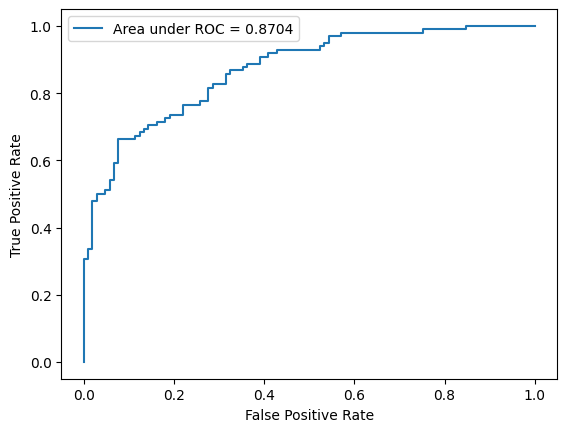

In [ ]:
# plot the roc curve    
fpr, tpr, _ = roc_curve(y_label, y_score)
plt.plot(fpr, tpr, label = "Area under ROC = {:.4f}".format(roc_score))
plt.legend(loc = 'best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

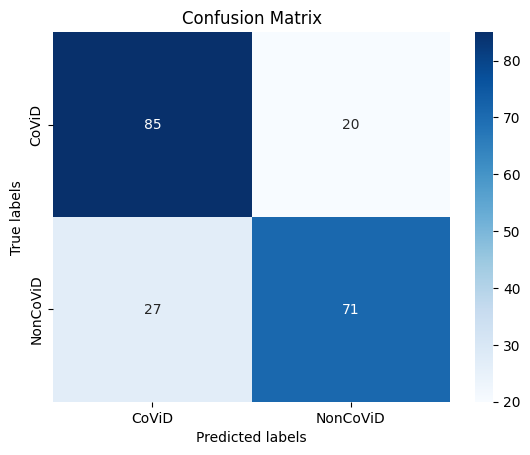

In [ ]:
import seaborn as sns

conf_matrix = conf_matrix
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap = 'Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['CoViD', 'NonCoViD']); ax.yaxis.set_ticklabels(['CoViD', 'NonCoViD']);

In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=bd4b7bc5e96b28254737f755d2b5f294ece72b5bcbbf2d771f858ffa5ff53362
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image

test_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    lambda x: x[:3],
    transforms.Normalize(mean=[0,0,0], std=[1,1,1])
])

def show_gradCAM(model, img):

    # target_layers = [model.layer4[-1]] # 출력층 이전 마지막 레이어 가져오기
    target_layers = [model.model_image.features[-2][-1]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True) 

    inp = test_transformer(img).unsqueeze(0) # 입력 이미지 transform
    targets = [ClassifierOutputTarget(1)] # 타겟 지정
    grayscale_cam = cam(input_tensor=inp, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # 활성화맵을 이미지 위에 표시
    visualization = show_cam_on_image(inp.squeeze(0).permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True) 

    pil_image=Image.fromarray(visualization)
    return pil_image

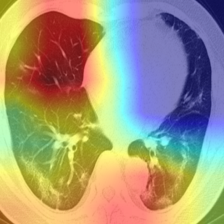

In [ ]:
covid = Image.open(root_dir + 'Covid_Test/1_CT_COVID/PIIS0140673620301549_0_0.png')
covid_cam = show_gradCAM(model, covid)
covid_cam